In [1]:
%matplotlib inline
from bottle import Bottle, route, run, template, get, post, debug, static_file, request, redirect, response
import time
import random
import string
import logging
import logging.handlers
import sqlite3
import datetime
import sqlite3
import sys, os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import names




## COVID-19 Tracker WebApp


- set up of the SQL database and the static_file and path

- redirection to the welcome page

## SET-UP

In [2]:
conn = sqlite3.connect('visitor.db')
c = conn.cursor()
conn.row_factory = sqlite3.Row

c.execute("CREATE TABLE IF NOT EXISTS visitor(visitor_id integer primary key autoincrement, first_name text not null, surname text not null, email text not null)")
c.execute("CREATE TABLE IF NOT EXISTS visit(visitor_id integer, arrival timestamp, depature timestamp)")


app = Bottle()


@app.route('/static/:path#.+#', name='static')
def static(path):
    return static_file(path, root='./static')

@app.route('/')
@app.route('/welcome')
@app.route('/welcome/')
@app.route('/welcome/<message>')
def welcome():
    return template('welcome')

- registration by entering name, surname, and email into the form of the webpage

- checking for doublets otherwise creating new vistor in database

- return of the message including the visitor-id to the template "register"

## Register

In [3]:
@app.route('/register')
@app.route('/register/')
@app.route('/register')
@app.post('/register')

def register():
    
    

    fname = request.forms.get('fname', default = None)
    sname = request.forms.get('sname', default = None)
    email = request.forms.get('email', default = None)
    
    if fname and sname and email != None:
        data1 = (fname, sname) 
        sqldoublete = "SELECT first_name surname FROM visitor WHERE first_name = ? AND surname =?"
           

        c.execute(sqldoublete, data1)
        a = c.fetchone()
        conn.commit()
        
        if a != None:
           
            message1 = "The Name already exists!"
            conn.commit()
            return template('register', message1=message1)
            
        else:
            c.execute("INSERT INTO visitor VALUES (?,?,?,?)", (None, fname, sname, email))
           
            c.execute("SELECT visitor_id FROM visitor ORDER by visitor_id DESC ")
           
            i = c.fetchone()
            print(type(i))
            visitorid = ''.join(map(str, i))
            
            message1 = "Your Visitor-ID is: " + visitorid + ". Please keep it in mind you will need it later"
            conn.commit()
            return template('register', message1=message1)
        
        conn.commit()
        return template('register', message1=message1)
    else:
        message1 = ""
        return template('register', message1=message1)
            
    

- automically input of arrival time into database by entering visitor-id

## New Visit

In [4]:
@app.route('/arrival')
@app.route('/arrival/')
@app.route('/arrival/<message>')
@app.post('/arrival')

def arrival():
    message2 = " "
    visitor_id = request.forms.get('visitor_id', default = False)

    c.execute("SELECT visitor_id FROM visitor WHERE visitor_id = ?", (visitor_id,))
    i = c.fetchone()   
    
    if i == None:
        
        
        message2 = "You are not registered yet. Please register at first! Thank you"
        template('arrival', message2 = message2)
        
    else:
        c.execute("INSERT INTO visit VALUES (?,?,?)", (visitor_id, datetime.datetime.now(), None))

      
        message2 =  "Welcome at XYZ."
        conn.commit() 
    message2 = ""
    return template('arrival', message2 = message2)
   

## Depature

In [5]:
@app.route('/depature')
@app.route('/depature/')
@app.route('/depature/<message>')
@app.post('/depature')

def depature():
    message3 = ""
    visitor_id = request.forms.get('visitor_id', default = False)
    
    if visitor_id == False:
        
        message3 = "Please enter a valid visitor-id."
        return template('depature', message3 = message3)
    
    else:
        sqlupdate2 = "UPDATE visit SET depature = ? WHERE visitor_id = ?"
        data2 = (datetime.datetime.now(), visitor_id)
        c.execute(sqlupdate2, data2)
        
        message3 = "Thank you for your visit."
        
        conn.commit()
        return template('depature', message3 = message3)
    
    return template('depature', message3 = message3)
    

- report of COVID-19 infection by entering visitor-id
- the program will show all visitors which were at the same time at the location
- the program will output a csv table containing all personal information of the visitors with potential contact to the COVID-19 infected
- aditional outputs of plots for gerneral data analysis through pandas

## Report Covid-19 infection

In [6]:
@app.route('/corona')
@app.route('/corona/')
@app.route('/corona/<message>')
@app.post('/corona')

def corona():
    

    
    #1. identification of infected customer and date/time of visit
    message4 = ""
    visitor_id = request.forms.get('visitor_id', default = False)
    
    
    c.execute("SELECT arrival FROM visit WHERE visitor_id = ?",  (visitor_id,))
    
    arrival = c.fetchone()
    
    c.execute("SELECT depature FROM visit WHERE visitor_id = ?",  (visitor_id,))
    
    depature = c.fetchone()
  
    if isinstance(arrival, tuple):
        
        arrival_t = arrival[0]
        depature_t = depature[0]
        
        
        #2. identification of all visits in this time 
        
        c.execute("SELECT * FROM visit WHERE arrival <= ? AND depature >= ?", (depature_t, arrival_t))
        covidvisits = c.fetchall()
       
        
        message4 = []
        
        for item in covidvisits:
            
        #3. connection of visits to visitor database
            
            sqlselect3 = "SELECT * FROM visitor WHERE visitor_id = ?"
            data4 = (item[0],)
            
            
               
            c.execute(sqlselect3, data4)
            
    
            
            listall = c.fetchone()
            print(listall)
          
            message4.append(listall)
               
        
            conn.commit()
            
        else:
        #4. display contact persons and general information about visits
            
            
            df1 = pd.DataFrame(message4, columns =['visitor_id', 'first_name', 'surname','email']) 
            df1.to_csv('COVIDcontacts.csv')
            
            
            df2 = pd.read_sql_query("SELECT * FROM visitor", conn)
        
            df2 = df2.assign(contact_infected=df2.visitor_id.isin(df1.visitor_id).astype(int))
            
            c.execute('''DROP TABLE IF EXISTS Visitor_Corona''')
            df2.to_sql('Visitor_Corona', conn, if_exists='replace', index=False)
        
           
            
            return template('corona')
        
        
        
            
    else:
        return template('corona')
    


- graphical visualization of the gathered data
- dataframe from sql data base
- visualization of share of contacts to infected as well as frequency of arrival and depature times by hour

In [7]:

@app.route('/analysis')
@app.route('/analysis/')
@app.route('/analysis/<message>')
@app.post('/analysis')

def analysis():
    
    
    contacts = pd.read_sql_query("SELECT * FROM Visitor_Corona", conn)
    print(contacts)
    
    a = contacts.groupby('contact_infected').size()
    a.plot.pie(figsize=(7,7), title = "Share of Contacts to Infectecd of Total Visitors", labels = ("Contact to Infected","No Contact to Infected"), y = " " , x= " ")
    plt.savefig('./static/pie.png')
    
    plt.show()
    
    
    visit = pd.read_sql_query("SELECT * FROM visit", conn)
    
    visit['arrival'] =  pd.to_datetime(visit['arrival'], format= "%Y/%m/%d %H:%M:%S")
    
   
    visit["hour_a"] = visit.arrival.dt.hour
    
    visit['hour_a'].value_counts().sort_index().plot(kind='bar', figsize = (7,7), title = "Frequency of arrival (by hour)")
    plt.savefig('./static/hours_arrival.png')
    plt.show()
     
    visit['depature'] =  pd.to_datetime(visit['depature'], format= "%Y/%m/%d %H:%M:%S")
    
    
    visit["hour_d"] = visit.depature.dt.hour
    
    visit['hour_d'].value_counts().sort_index().plot(kind='bar', figsize = (7,7), title = "Frequency of depature (by hour)")
    plt.savefig('./static/hours_depature.png')
    plt.show()

    
    return template('analysis')


- set up for graphs in template

In [8]:
@route('/static/<filename>')
def server_static(filename):
    return static_file(filename, root='./graphs')

- execution of app

Bottle v0.12.19 server starting up (using WSGIRefServer())...
Listening on http://localhost:63860/
Hit Ctrl-C to quit.

127.0.0.1 - - [12/May/2021 13:55:06] "GET / HTTP/1.1" 200 1811
127.0.0.1 - - [12/May/2021 13:55:06] "GET /static/css/bootstrap-theme.min.css HTTP/1.1" 200 23409
127.0.0.1 - - [12/May/2021 13:55:18] "GET /register HTTP/1.1" 200 1865
127.0.0.1 - - [12/May/2021 13:55:21] "GET /arrival HTTP/1.1" 200 1768
127.0.0.1 - - [12/May/2021 13:55:55] "GET /arrival HTTP/1.1" 200 1768
127.0.0.1 - - [12/May/2021 13:55:56] "GET /depature HTTP/1.1" 200 1801
127.0.0.1 - - [12/May/2021 13:56:07] "GET /corona HTTP/1.1" 200 1688
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py", line 1586, in execute
    cur.execute(*args, **kwargs)
sqlite3.OperationalError: no such table: Visitor_Corona

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/philipp/opt/anaco

<class 'tuple'>


127.0.0.1 - - [12/May/2021 13:56:23] "POST /register HTTP/1.1" 200 1933
127.0.0.1 - - [12/May/2021 13:56:28] "GET /arrival HTTP/1.1" 200 1768
127.0.0.1 - - [12/May/2021 13:56:32] "POST /arrival HTTP/1.1" 200 1768
127.0.0.1 - - [12/May/2021 13:56:35] "GET /depature HTTP/1.1" 200 1801
127.0.0.1 - - [12/May/2021 13:56:38] "POST /depature HTTP/1.1" 200 1794
127.0.0.1 - - [12/May/2021 13:56:53] "GET /corona HTTP/1.1" 200 1688


(1, 'Philipp', 'Pecher', 'ppecher@gmail.com')


127.0.0.1 - - [12/May/2021 13:57:01] "POST /corona HTTP/1.1" 200 1688


   visitor_id first_name surname              email  contact_infected
0           1    Philipp  Pecher  ppecher@gmail.com                 1


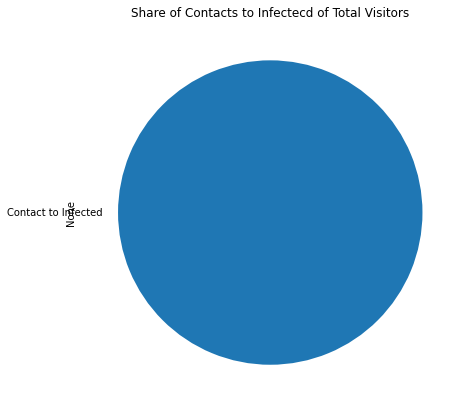

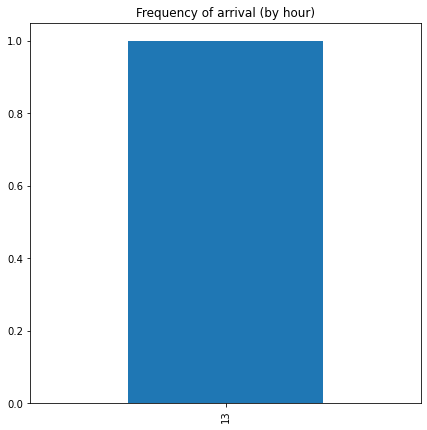

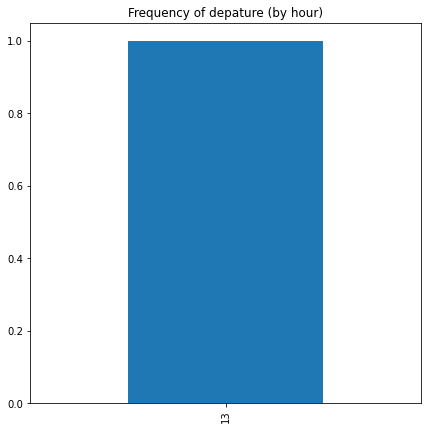

127.0.0.1 - - [12/May/2021 13:57:02] "GET /analysis HTTP/1.1" 200 1781
127.0.0.1 - - [12/May/2021 13:57:02] "GET /static/pie.png HTTP/1.1" 200 15109
127.0.0.1 - - [12/May/2021 13:57:02] "GET /static/hours_arrival.png HTTP/1.1" 200 8219
127.0.0.1 - - [12/May/2021 13:57:02] "GET /static/hours_depature.png HTTP/1.1" 200 8570
127.0.0.1 - - [12/May/2021 13:57:52] "GET / HTTP/1.1" 200 1811
127.0.0.1 - - [12/May/2021 13:58:37] "GET /corona HTTP/1.1" 200 1688


(2, 'Maria', 'Young', 'MariaYoung@gmail.com')
(4, 'Rebecca', 'Carter', 'RebeccaCarter@gmail.com')
(5, 'John', 'Burnside', 'JohnBurnside@gmail.com')
(6, 'Kevin', 'Padmore', 'KevinPadmore@gmail.com')
(7, 'Lisa', 'Wyrick', 'LisaWyrick@gmail.com')
(8, 'Katherine', 'Chasse', 'KatherineChasse@gmail.com')
(9, 'Jerry', 'Cramblit', 'JerryCramblit@gmail.com')
(10, 'Paul', 'Smith', 'PaulSmith@gmail.com')
(11, 'Lisa', 'Gonzales', 'LisaGonzales@gmail.com')
(12, 'Doris', 'Bass', 'DorisBass@gmail.com')
(14, 'Cynthia', 'Dean', 'CynthiaDean@gmail.com')
(15, 'Eugene', 'Labine', 'EugeneLabine@gmail.com')
(16, 'Lorraine', 'Diaz', 'LorraineDiaz@gmail.com')
(18, 'Fernando', 'Williams', 'FernandoWilliams@gmail.com')
(19, 'Rolando', 'Phariss', 'RolandoPhariss@gmail.com')
(20, 'Joseph', 'Mcgruder', 'JosephMcgruder@gmail.com')
(21, 'Elaine', 'Stroud', 'ElaineStroud@gmail.com')
(22, 'Gerald', 'Finch', 'GeraldFinch@gmail.com')
(23, 'Doris', 'Deblauw', 'DorisDeblauw@gmail.com')
(24, 'Nathaniel', 'Ortega', 'Nathani

127.0.0.1 - - [12/May/2021 13:58:48] "POST /corona HTTP/1.1" 200 1688


     visitor_id first_name   surname                    email  \
0             1    Philipp    Pecher        ppecher@gmail.com   
1             2      Maria     Young     MariaYoung@gmail.com   
2             3     Robert   Dunagan  RobertDunagan@gmail.com   
3             4    Rebecca    Carter  RebeccaCarter@gmail.com   
4             5       John  Burnside   JohnBurnside@gmail.com   
..          ...        ...       ...                      ...   
995         996    Heather    Oliver  HeatherOliver@gmail.com   
996         997     Pamela     Jones    PamelaJones@gmail.com   
997         998      Donna     Allen     DonnaAllen@gmail.com   
998         999     Melvin      Mize     MelvinMize@gmail.com   
999        1000    Michael      Roth    MichaelRoth@gmail.com   

     contact_infected  
0                   0  
1                   1  
2                   0  
3                   1  
4                   1  
..                ...  
995                 1  
996                 1  
997

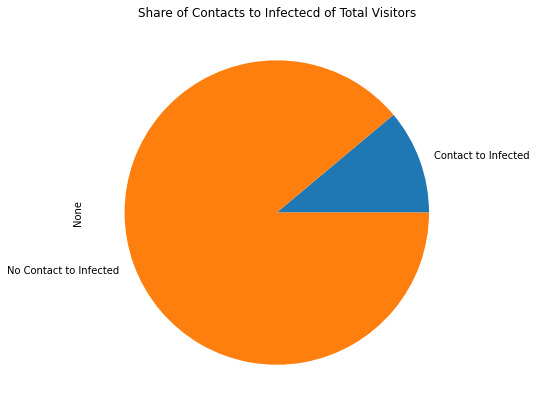

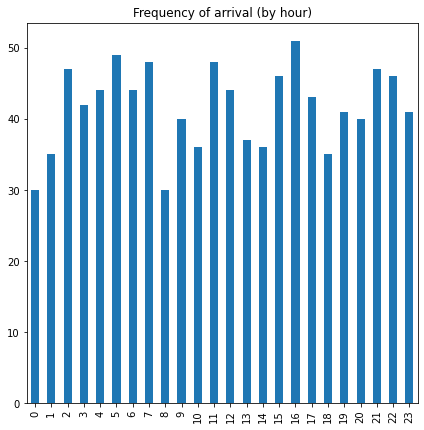

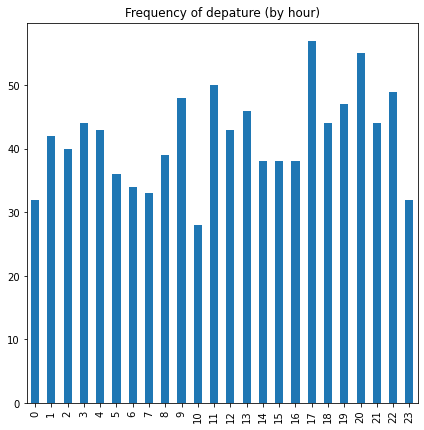

127.0.0.1 - - [12/May/2021 13:58:50] "GET /analysis HTTP/1.1" 200 1781
127.0.0.1 - - [12/May/2021 13:58:50] "GET /static/pie.png HTTP/1.1" 200 17083
127.0.0.1 - - [12/May/2021 13:58:50] "GET /static/hours_arrival.png HTTP/1.1" 200 10935
127.0.0.1 - - [12/May/2021 13:58:50] "GET /static/hours_depature.png HTTP/1.1" 200 11272
127.0.0.1 - - [12/May/2021 13:58:50] "GET /static/pie.png HTTP/1.1" 200 17083
127.0.0.1 - - [12/May/2021 13:58:50] "GET /static/hours_arrival.png HTTP/1.1" 200 10935
127.0.0.1 - - [12/May/2021 13:58:50] "GET /static/hours_depature.png HTTP/1.1" 200 11272
127.0.0.1 - - [12/May/2021 13:59:10] "GET / HTTP/1.1" 200 1811


In [ ]:
app.run(host='localhost', port=63860, reloader=False, debug=True)